<a href="https://www.kaggle.com/code/danieleldan/spaceship-titanic?scriptVersionId=109965860" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><center>Spaceship Titanic</center></h1>
<h3><center>Welcome to my journey through space and data science</center></h3>
    <h3><center>Put on your seat belt and enjoy the ride</center></h3>

6th try. I pulled a bit the data and try an ensemble model. Not best than my best try, but it's a new way to achieve to top100

**Import Libraries**

In [64]:
import numpy as np
import pandas as pd
import re
import time
import random

#models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

#tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

pd.options.mode.chained_assignment = None 

**Load data**

In [2]:
# Load data
train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
test_df = pd.read_csv("../input/spaceship-titanic/test.csv")


**First look**

In [3]:
train_df.head(20).style.background_gradient(cmap="Blues")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.000000,False,0.000000,483.000000,0.000000,291.000000,0.000000,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.000000,False,42.000000,1539.000000,3.000000,0.000000,0.000000,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.000000,False,0.000000,0.000000,0.000000,0.000000,nan,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.000000,False,0.000000,785.000000,17.000000,216.000000,0.000000,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Erraiam Flatic,True


# **EXPLORATORY DATA ANALYSIS**

## First look of the data. What we can see?

* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

    * **PassengerId** - I split PassengerId in PassengerId_Ticket and PassengerId_Unique, then, create boolean column IsGrouped to identify people who travel in group and share cabin. Also, created a columns with the size of the group, that may be interesting thinking in "the energy required for the spacetime anomaly to transport people".
    
    * **HomePlanet** - First I look for the HomePlanet of people who share ticket number and repeat it. We are ignoring people who don't travel together but share cabin. We assume all travel together like a family. Then I fill acording to the probabilies 
    
    * **CryoSleep** - First, I look if the person had spent some money. If yes, CryoSleep NaN is filled with False, because a slept person can't spend money. If the person had not spent any money, I fill with True, because an awake person "should spent even a little money." The rest of the NaNs were filled by completing the "Bill_Columns".
    
    * **Cabin** - Split Cabin into Deck, Num and Side. First I have checked the cabin of people who share ticket number, ergo, travel together in the same cabin. Then, I filled acording to the probabilities acording the HomePlanet of the person.
    
    * **Destination** - I used the same strategy of HomePlanet.
    
    * **Age** - I created columns IsAdult >= 18 <40 | IsMiddleAge >= 40 < 60 | IsOldAge >= 60
    
    * **VIP** - First, NaNs VIP people who had not spent any should not be VIP. Then, if they have spent more than the mean of the sum of RoomService, FoodCourt, ShoppingMall, Spa and VRDeck, is True, the rest, False.
    
    * **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - First, if person is in CryoSleep, then, can not spent any money, so the NaNs where filled with 0. Then, if isn't CryoSleep and had spent any, the NaN was filled with the columns mean, if not, filled with 0 (Could spent after, if the ship have not crashed xD).
    
    * **Name** - Nothing this time, I droped it.
    
    * **Transported** - Our precious

* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [4]:
#How many NaNs do we have?
train_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
# Help function
def isNaN(string):
    return string != string

In [6]:
# Help function 2

def check_destination(homeplanet):
    if homeplanet == "Mars":
        i = np.random.random()
        if i <= m_to_trappist/t_from_mars:
            return "TRAPPIST-1e"
        elif i > m_to_trappist/t_from_mars and i <= (m_to_trappist/t_from_mars)+(m_to_cancri/t_from_mars):
            return "55 Cancri e"
        elif i > 1-m_to_cancri/t_from_mars:
            return "PSO J318.5-22"
        
    if homeplanet == "Earth":
        i = np.random.random()
        if i <= e_to_trappist/t_from_earth:
            return "TRAPPIST-1e"
        elif i > e_to_trappist/t_from_earth and i <= (e_to_trappist/t_from_earth)+(e_to_pso/t_from_earth):
            return "55 Cancri e"
        elif i > 1-e_to_pso/t_from_earth:
            return "PSO J318.5-22"

    if homeplanet == "Europa":
        i = np.random.random()
        if i <= eu_to_trappist/t_from_europa:
            return "TRAPPIST-1e"
        elif i > eu_to_trappist/t_from_europa and i <= (eu_to_trappist/t_from_europa)+(eu_to_cancri/t_from_europa):
            return "55 Cancri e"
        elif i > 1-eu_to_cancri/t_from_europa:
            return "PSO J318.5-22"

In [7]:
# Split first and last name to new columns
train_df[['F_Name','L_Name']] = train_df["Name"].str.split(' ', expand=True)
test_df[['F_Name','L_Name']] = test_df["Name"].str.split(' ', expand=True)

In [8]:
#Populars names
train_df["F_Name"].value_counts()

Idace      13
Loree      12
Glena      11
Gwendy     11
Kaye       11
           ..
Capies      1
Blues       1
Preonon     1
Siese       1
Chain       1
Name: F_Name, Length: 2706, dtype: int64

In [9]:
#Relatives traveling together.
train_df["L_Name"].value_counts()

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
              ..
Covale         1
Dun            1
Witalnerod     1
Deryplinet     1
Sionerorly     1
Name: L_Name, Length: 2217, dtype: int64


**Split PassengerId in Ticket and Unique. This is because "grouped tickets"**

In [10]:
# Split passengerId in ticket and unique to look people traveling in the same room
train_df[['PassengerId_Ticket', 'PassengerId_Unique']] = train_df['PassengerId'].str.split('_', expand=True)
test_df[['PassengerId_Ticket', 'PassengerId_Unique']] = test_df['PassengerId'].str.split('_', expand=True)

**Create a new column to identify people who travel in group**

In [11]:
# Train df first
serie = []
for i in train_df["PassengerId_Ticket"].values:
    if i in train_df["PassengerId_Ticket"][train_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
train_df['IsGrouped'] = serie.tolist()
train_df = train_df.astype({"IsGrouped": bool})

# Test df

serie = []
for i in test_df["PassengerId_Ticket"].values:
    if i in test_df["PassengerId_Ticket"][test_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
test_df['IsGrouped'] = serie.tolist()
test_df = test_df.astype({"IsGrouped": bool})

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,0001,01,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,0002,01,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,0003,01,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,0003,02,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,0004,01,False


**Create a column with the size of each group**

In [12]:
train_df['Group_Size'] = train_df['PassengerId_Ticket'].map(lambda x: train_df['PassengerId_Ticket'].value_counts()[x])
test_df['Group_Size'] = test_df['PassengerId_Ticket'].map(lambda x: test_df['PassengerId_Ticket'].value_counts()[x])

In [13]:
#Most people travel alone or in couples. 

train_df["Group_Size"].value_counts()

1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: Group_Size, dtype: int64

# Plotting the data to see what it looks like

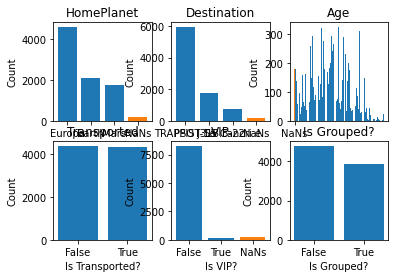

In [14]:
plt.figure()

# HomePlanet
plt.subplot(2,3,1)
plt.bar(train_df["HomePlanet"].dropna().unique(),train_df["HomePlanet"].value_counts())
plt.bar("NaNs",train_df["HomePlanet"].isna().sum())
plt.title("HomePlanet")
plt.xlabel("Origin")
plt.ylabel("Count")

#Destination Planet
plt.subplot(2,3,2)
plt.bar(train_df["Destination"].dropna().unique(),train_df["Destination"].value_counts())
plt.bar("NaNs",train_df["Destination"].isna().sum())
plt.title("Destination")
plt.xlabel("Destination")
plt.ylabel("Count")

# People's Age
plt.subplot(2,3,3)
plt.bar(train_df["Age"].dropna().unique(),train_df["Age"].value_counts())
plt.bar("NaNs",train_df["Age"].isna().sum())
plt.title("Age")
plt.xlabel("Age")
plt.ylabel("Count")

# Is Transported??
plt.subplot(2,3,4)
plt.bar(["False","True"],train_df["Transported"].value_counts())
plt.title("Transported")
plt.ylabel("Count")
plt.xlabel("Is Transported?")

# How many VIPs?
plt.subplot(2,3,5)
plt.bar(["False","True"],train_df["VIP"].value_counts())
plt.bar("NaNs",train_df["VIP"].isna().sum())
plt.title("VIP")
plt.ylabel("Count")
plt.xlabel("Is VIP?")

#Traveling in group
plt.subplot(2,3,6)
plt.bar(["False","True"],train_df["IsGrouped"].value_counts())
plt.title("Is Grouped?")
plt.ylabel("Count")
plt.xlabel("Is Grouped?")

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

In [15]:
# Split Cabin deck/num/side in three different columns

train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

# Filling NaNs

### RoomService - FoodCourt - ShoppingMall - Spa - VRDeck
If a person is on CryoSleep, could spend some money? Obviously no, so we are gonna fill "RoomService", "FoodCourt", "ShoppingMall", "Spa" and "VRDeck" NaNs with 0 when "CryoSleep is True (Sleeping).

When CryoSleep is False (Awake) we are gonna fill the NaNs with the mean of each column, assuming that a "awake" person may spend some money in the journey.

We are going to suposse that the NaNs values exists because of the "colission" with the space-time anomaly.

In [16]:
#Remember how many NaNs we have
train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep             217
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
Deck                  199
Num                   199
Side                  199
dtype: int64

In [17]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#Fill bill_columns with 0 when cryosleep is True

for x in train_df[bill_columns].columns:
    aux = 0
    for a in train_df[x]:
        if train_df["CryoSleep"][aux] == True and np.isnan(a):
            train_df[x][aux] = 0
        aux += 1

for x in test_df[bill_columns].columns:
    aux = 0
    for a in test_df[x]:
        if test_df["CryoSleep"][aux] == True and np.isnan(a):
            test_df[x][aux] = 0
        aux += 1

### CryoSleep
I filled all the NaNs when CryoSleep is True, but we have some NaNs in CryoSleep, so we are gonna fill them with True if all the "spend" columns are 0. Assuming if somebody doesn't spend money it's because he's asleep.

In [18]:
# I made two functions because I will need them later.

def fill_cryosleep_true():
    bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for x in train_df[bill_columns].columns:
        aux = 0
        for a in train_df[x]:
            if np.isnan(train_df["CryoSleep"][aux]) and (train_df["RoomService"][aux]
                                                      +train_df["FoodCourt"][aux]
                                                      +train_df["ShoppingMall"][aux]
                                                      +train_df["Spa"][aux]
                                                      +train_df["VRDeck"][aux])== 0:
                train_df["CryoSleep"][aux] = True
            aux += 1

    for x in test_df[bill_columns].columns:
        aux = 0
        for a in test_df[x]:
            if np.isnan(test_df["CryoSleep"][aux]) and (test_df["RoomService"][aux]
                                                      +test_df["FoodCourt"][aux]
                                                      +test_df["ShoppingMall"][aux]
                                                      +test_df["Spa"][aux]
                                                      +test_df["VRDeck"][aux])== 0:
                test_df["CryoSleep"][aux] = True
            aux += 1
            
fill_cryosleep_true()            

Now, if a person spend some in different services, should not be sleep. So, every NaN CryoSleep where the person have spent will become False.

In [19]:
def fill_cryosleep_false():
    bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for x in train_df[bill_columns].columns:
        aux = 0
        for a in train_df[x]:
            if np.isnan(train_df["CryoSleep"][aux]) and (train_df["RoomService"][aux]
                                                      +train_df["FoodCourt"][aux]
                                                      +train_df["ShoppingMall"][aux]
                                                      +train_df["Spa"][aux]
                                                      +train_df["VRDeck"][aux])> 0:
                train_df["CryoSleep"][aux] = False
            aux += 1

    for x in test_df[bill_columns].columns:
        aux = 0
        for a in test_df[x]:
            if np.isnan(test_df["CryoSleep"][aux]) and (test_df["RoomService"][aux]
                                                      +test_df["FoodCourt"][aux]
                                                      +test_df["ShoppingMall"][aux]
                                                      +test_df["Spa"][aux]
                                                      +test_df["VRDeck"][aux])> 0:
                test_df["CryoSleep"][aux] = False
            aux += 1
            
fill_cryosleep_false()

In [20]:
#Check Cryosleep nans remaining

train_df[(train_df["CryoSleep"] != False) & (train_df["CryoSleep"] != True)].head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size,Deck,Num,Side
111,0115_01,Mars,NaN,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,...,True,Rohs,Pead,0115,01,False,1,F,24,P
1531,1624_03,Earth,NaN,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,...,True,Eristy,Barbes,1624,03,True,3,G,250,S
2134,2291_01,Earth,NaN,55 Cancri e,6.0,False,0.0,0.0,0.0,NaN,...,False,Patoya,Pittler,2291,01,True,3,G,365,S
2231,2390_01,Earth,NaN,TRAPPIST-1e,24.0,False,0.0,0.0,NaN,59.0,...,False,Joelan,Burrilllins,2390,01,False,1,G,385,P
2402,2584_01,Earth,NaN,PSO J318.5-22,21.0,False,0.0,0.0,NaN,0.0,...,False,Lilace,Woodwardy,2584,01,False,1,G,417,P


**Now we have CryoSleep NaN & spend_columns NaN.**

1. If there is no other spent money in columns we are gonna fill the NaN with 0.

2. If there is a spend money in columns we are gonna fill the NaN with the mean.

**Then, we are going to repeat the CryoSleep NaNs filling if there is spent money or not**

In [21]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa','VRDeck']

#Fill with 0 if is no more money spent

for i in np.arange(len(train_df)):
    aux = 0
    
    for a in train_df[bill_columns].columns:
        if not np.isnan(train_df[a][i]):
            aux = aux + train_df[a][i]
            
    for b in train_df[bill_columns].columns:
        if np.isnan(train_df[b][i]) and aux > 0.0:
            train_df[b][i] = train_df[b].mean()
            
    for c in train_df[bill_columns].columns:
        if np.isnan(train_df[c][i]) and aux == 0.0:
            train_df[c][i] = 0

In [22]:
#Fill with the mean if the is some money spent.

for i in np.arange(len(test_df)):
    aux = 0
    
    for a in test_df[bill_columns].columns:
        if not np.isnan(test_df[a][i]):
            aux = aux + test_df[a][i]
            
    for b in test_df[bill_columns].columns:
        if np.isnan(test_df[b][i]) and aux > 0.0:
            test_df[b][i] = test_df[b].mean()
            
    for c in test_df[bill_columns].columns:
        if np.isnan(test_df[c][i]) and aux == 0.0:
            test_df[c][i] = 0

### TotalSpent
**Add column TotalSpent**

It may be interesting to know how much money people have spent

In [23]:
train_df['TotalSpent'] = train_df['RoomService'] + train_df['FoodCourt'] + train_df['ShoppingMall'] + train_df['Spa'] + train_df['VRDeck']
test_df['TotalSpent'] = test_df['RoomService'] + test_df['FoodCourt'] + test_df['ShoppingMall'] + test_df['Spa'] + test_df['VRDeck']


**CONTINUE to clean the DataFrame.**

In [24]:
fill_cryosleep_true()
fill_cryosleep_false()

train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep               0
Destination           182
Age                   179
VIP                   203
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
Deck                  199
Num                   199
Side                  199
TotalSpent              0
dtype: int64

### VIP

**Check the VIP nans**

If there is 0 TotalSpent then is no VIP. C'mon!

In [25]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["VIP"][i]) and train_df["TotalSpent"][i] == 0:
        train_df["VIP"][i] = False
        
for i in np.arange(len(test_df)):
    if isNaN(test_df["VIP"][i]) and test_df["TotalSpent"][i] == 0:
        test_df["VIP"][i] = False

**if there is more o equal TotalSpent than true VIPS Spent, then, is VIP.**

In [26]:
#The mean of the money spent by VIP people

train_df["TotalSpent"][train_df["VIP"]==True].mean()

4449.797337001945

In [27]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["VIP"][i]) and (train_df["TotalSpent"][i] >= (train_df["TotalSpent"][train_df["VIP"]==True].mean())):
        train_df["VIP"][i] = True
        
for i in np.arange(len(test_df)):
    if isNaN(test_df["VIP"][i]) and (test_df["TotalSpent"][i] >= (test_df["TotalSpent"][test_df["VIP"]==True].mean())):
        test_df["VIP"][i] = True

### HomePlanet

We are going to fill "HomePlanet" NaNs of Grouped tickets with the HomePlanet of their roommates

In [28]:
aux = 0
for i in np.arange(len(train_df)):
    
    if isNaN(train_df["HomePlanet"][i]) and train_df["IsGrouped"][i] == True:
        
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
            train_df["HomePlanet"][i] = train_df["HomePlanet"][i+1]
        elif train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
            train_df["HomePlanet"][i] = train_df["HomePlanet"][i-1]

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["HomePlanet"][i]) and test_df["IsGrouped"][i] == True:
        
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
            test_df["HomePlanet"][i] = train_df["HomePlanet"][i+1]
        elif test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
            test_df["HomePlanet"][i] = test_df["HomePlanet"][i-1]

In [29]:
train_df["HomePlanet"].fillna(method="ffill", inplace=True)

test_df["HomePlanet"].fillna(method="ffill", inplace=True)

### Cabin: Deck - Num - Side

**An aproach to where people are in the SpaceShip Titanic**

In [30]:
train_df["Deck"].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

**Earth's people don't travel on B, C, D, A or T Deck**

**Mar's people don't travel on T, A, C, B, or G Deck**

**Europa's people don't travel on F, G Deck**

**Lasts HomePlanet NaNs are going to be filled by random assign a planet by the Deck selected**

**THIS ONLY APPLY ON TRAIN DATAFRAME but we are going to fill the same in test df**

In [31]:
F_Deck = ["Earth","Mars"]
G_Deck = ["Earth"]
E_Deck = ["Earth","Mars","Europa"]
B_Deck = C_Deck = A_Deck = T_Deck = ["Europa"]
D_Deck = ["Mars","Europa"]


def check_deck(string):
    if string == "F":
        return F_Deck
    elif string == "G":
        return G_Deck
    elif string == "E":
        return E_Deck
    elif string == "B" or string == "C" or string == "T" or string == "A":
        return B_Deck
    elif string == "D":
        return D_Deck

for i in np.arange(len(train_df)):
    
    if isNaN(train_df["HomePlanet"][i]) and isNaN(train_df["Deck"][i]) == False:
        train_df["HomePlanet"][i] = random.choice(check_deck(train_df["Deck"][i]))

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["HomePlanet"][i]) and isNaN(test_df["Deck"][i]) == False:
        test_df["HomePlanet"][i] = random.choice(check_deck(test_df["Deck"][i]))

Filling deck, num and side with their roommate's

In [32]:

fill_aux = ["Deck","Num","Side"]
for i in np.arange(len(train_df)):
    for a in fill_aux: 
        if isNaN(train_df[a][i]) and train_df["IsGrouped"][i] == True:

            if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
                train_df[a][i] = train_df[a][i+1]
            if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
                train_df[a][i] = train_df[a][i-1]
                
for i in np.arange(len(test_df)):
    for a in fill_aux: 
        if isNaN(test_df[a][i]) and test_df["IsGrouped"][i] == True:

            if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
                test_df[a][i] = test_df[a][i+1]
            if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
                test_df[a][i] = test_df[a][i-1]

In [33]:
train_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = train_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')

train_df[['CryoSleep', 'VIP']] = train_df[['CryoSleep', 'VIP']].astype('bool')

test_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = test_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')

test_df[['CryoSleep', 'VIP']] = test_df[['CryoSleep', 'VIP']].astype('bool')

In [34]:
Earth_Decks = ["F","G","E"]
Mars_Decks = ["F","E","D"]
Europas_Decks = ["E","B","C","A","T","D"]

def check_homeplanet(string):
    if string == "Earth":
        return Earth_Decks
    elif string == "Mars":
        return Mars_Decks
    elif string == "Europa":
        return Europas_Decks

for i in np.arange(len(train_df)):
    if isNaN(train_df["Deck"][i]):
        train_df["Deck"][i] = random.choice(check_homeplanet(train_df["HomePlanet"][i]))

for i in np.arange(len(test_df)):
    if isNaN(test_df["Deck"][i]):
        test_df["Deck"][i] = random.choice(check_homeplanet(test_df["HomePlanet"][i]))

In [35]:
train_df.isna().sum()


PassengerId             0
HomePlanet              0
CryoSleep               0
Destination           182
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
Deck                    0
Num                    99
Side                   99
TotalSpent              0
dtype: int64

**Num: I will pick up the max Num and check for the free cabins. So I assign Num-Nans a freee cabin between the min a max num**

**Update: There is no free cabins HAHAHA so I assigned a new cabin not used before for each NaN**

In [36]:
#1894 max value in train df
max_value = 1894 + 1
for i in np.arange(len(train_df)):
    if isNaN(train_df["Num"][i]):
        train_df["Num"][i] = max_value
        max_value = max_value + 1

#1503 max value in test df

max_value = 1503 + 1
for i in np.arange(len(test_df)):
    if isNaN(test_df["Num"][i]):
        test_df["Num"][i] = max_value
        max_value = max_value + 1
        


In [37]:
# Side will be filled randomly
Sides = ["S","P"]
for i in np.arange(len(train_df)):
    if isNaN(train_df["Side"][i]):
        train_df["Side"][i] = random.choice(Sides)

        
for i in np.arange(len(test_df)):
    if isNaN(test_df["Side"][i]):
        test_df["Side"][i] = random.choice(Sides)

In [38]:
train_df.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Destination           182
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
Deck                    0
Num                     0
Side                    0
TotalSpent              0
dtype: int64

### Destination

**Same threatment of HomePlanet. Let's see the destination of their roommates**

In [39]:
for i in np.arange(len(train_df)):
    
    if isNaN(train_df["Destination"][i]) and train_df["IsGrouped"][i] == True:
        
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
            train_df["Destination"][i] = train_df["Destination"][i+1]
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
            train_df["Destination"][i] = train_df["Destination"][i-1]
            
for i in np.arange(len(test_df)):
    
    if isNaN(test_df["Destination"][i]) and test_df["IsGrouped"][i] == True:
        
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
            test_df["Destination"][i] = train_df["Destination"][i+1]
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
            test_df["Destination"][i] = test_df["Destination"][i-1]

**The rest NaNs of Destination are going to be filled by the probability from their HomePlanet**

In [40]:
t_from_mars = len(train_df[train_df["HomePlanet"] == "Mars"])
m_to_trappist = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "TRAPPIST-1e")])
m_to_cancri = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "55 Cancri e")])
m_to_pso = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "PSO J318.5-22")])

t_from_earth = len(train_df[train_df["HomePlanet"] == "Earth"])
e_to_trappist = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "TRAPPIST-1e")])
e_to_cancri = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "55 Cancri e")])
e_to_pso = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "PSO J318.5-22")])

t_from_europa = len(train_df[train_df["HomePlanet"] == "Europa"])
eu_to_trappist = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "TRAPPIST-1e")])
eu_to_cancri = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "55 Cancri e")])
eu_to_pso = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "PSO J318.5-22")])


In [41]:
t_from_mars = len(test_df[test_df["HomePlanet"] == "Mars"])
m_to_trappist = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "TRAPPIST-1e")])
m_to_cancri = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "55 Cancri e")])
m_to_pso = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "PSO J318.5-22")])

t_from_earth = len(test_df[test_df["HomePlanet"] == "Earth"])
e_to_trappist = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "TRAPPIST-1e")])
e_to_cancri = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "55 Cancri e")])
e_to_pso = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "PSO J318.5-22")])

t_from_europa = len(test_df[test_df["HomePlanet"] == "Europa"])
eu_to_trappist = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "TRAPPIST-1e")])
eu_to_cancri = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "55 Cancri e")])
eu_to_pso = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "PSO J318.5-22")])

In [42]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["Destination"][i]):
        train_df["Destination"][i] = check_destination(train_df["HomePlanet"][i])

In [43]:
for i in np.arange(len(test_df)):
    if isNaN(test_df["Destination"][i]):
        test_df["Destination"][i] = check_destination(test_df["HomePlanet"][i])

In [44]:
train_df.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Destination             0
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
Deck                    0
Num                     0
Side                    0
TotalSpent              0
dtype: int64

### Age

**Can't really see a pattern in Age, Im gonna fill Age with the mean**

In [45]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)
test_df["Age"].fillna(test_df["Age"].mean(), inplace=True)

**Create a Columns:**
1. IsAdult > 18 years <40
2. IsMiddleAge >= 40 < 65 years
3. IsOldAdult >= 65

In [46]:
train_df[['IsAdult','IsMiddleAge', 'IsOldAdult']]=True
train_df.loc[train_df['Age']<18, ['IsAdult', 'IsMiddleAge', 'IsOldAdult']]=False
train_df.loc[(train_df['Age']>=18)&(train_df['Age']<40), ['IsMiddleAge', 'IsOldAdult']]=False
train_df.loc[(train_df['Age']>=40)&(train_df['Age']<65), ['IsAdult', 'IsOldAdult']]=False
train_df.loc[(train_df['Age']>=65), ['IsAdult', 'IsMiddleAge']]=False

test_df[['IsAdult','IsMiddleAge', 'IsOldAdult']]=True
test_df.loc[test_df['Age']<18, ['IsAdult', 'IsMiddleAge', 'IsOldAdult']]=False
test_df.loc[(test_df['Age']>=18)&(test_df['Age']<40), ['IsMiddleAge', 'IsOldAdult']]=False
test_df.loc[(test_df['Age']>=40)&(test_df['Age']<65), ['IsAdult', 'IsOldAdult']]=False
test_df.loc[(test_df['Age']>=65), ['IsAdult', 'IsMiddleAge']]=False

**For this time im going to drop the Name**

In [47]:
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)

In [48]:
train_df.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
Deck                    0
Num                     0
Side                    0
TotalSpent              0
IsAdult                 0
IsMiddleAge             0
IsOldAdult              0
dtype: int64

# Adjusting type of the data

In [49]:

train_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = train_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')

test_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = test_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')

# New Plotting of the Data

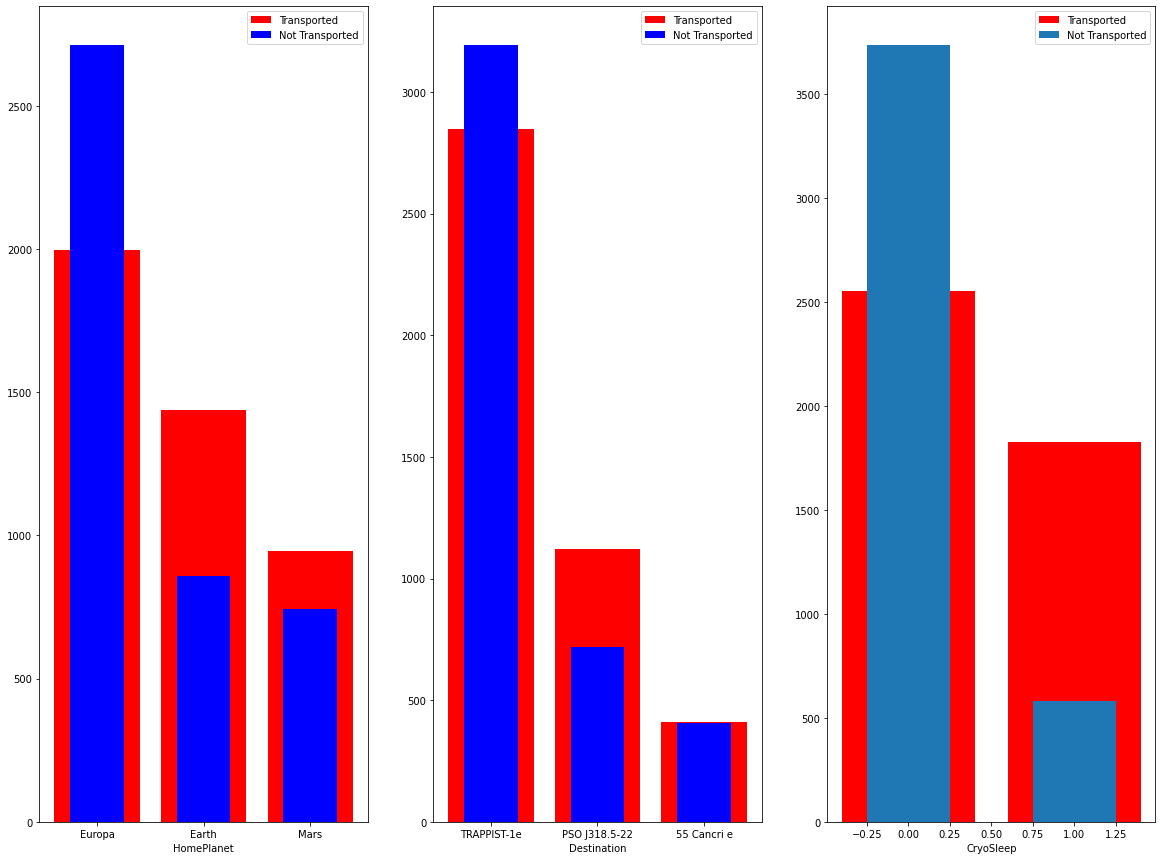

In [50]:
plt.figure()
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(1,3,1)
plt.bar(train_df["HomePlanet"].unique(),train_df["HomePlanet"][(train_df["Transported"] == True)].value_counts(), color="red", label="Transported")
plt.bar(train_df["HomePlanet"].unique(),train_df["HomePlanet"][(train_df["Transported"] == False)].value_counts(), color="blue",label="Not Transported", width=0.5)
plt.xlabel("HomePlanet")
plt.legend()

plt.subplot(1,3,2)
plt.bar(train_df["Destination"].unique(),train_df["Destination"][(train_df["Transported"] == True)].value_counts(), color="red", label="Transported")
plt.bar(train_df["Destination"].unique(),train_df["Destination"][(train_df["Transported"] == False)].value_counts(), color="blue", label="Not Transported", width=0.5)
plt.xlabel("Destination")
plt.legend()

plt.subplot(1,3,3)
plt.bar(train_df["CryoSleep"].unique(),train_df["CryoSleep"][(train_df["Transported"] == True)].value_counts(), color="red", label="Transported")
plt.bar(train_df["CryoSleep"].unique(),train_df["CryoSleep"][(train_df["Transported"] == False)].value_counts(), label="Not Transported", width=0.5)
plt.xlabel("CryoSleep")
plt.legend()

plt.legend()

plt.show()

In [51]:
train_df.head().style.background_gradient(cmap="Blues")

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size,Deck,Num,Side,TotalSpent,IsAdult,IsMiddleAge,IsOldAdult
0,0001_01,Europa,False,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,Maham,Ofracculy,1,1,False,1,B,0,P,0.000000,True,False,False
1,0002_01,Earth,False,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,True,Juanna,Vines,2,1,False,1,F,0,S,736.000000,True,False,False
2,0003_01,Europa,False,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,False,Altark,Susent,3,1,True,2,A,0,S,10383.000000,False,True,False
3,0003_02,Europa,False,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,False,Solam,Susent,3,2,True,2,A,0,S,5176.000000,True,False,False
4,0004_01,Earth,False,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,True,Willy,Santantines,4,1,False,1,F,1,S,1091.000000,False,False,False


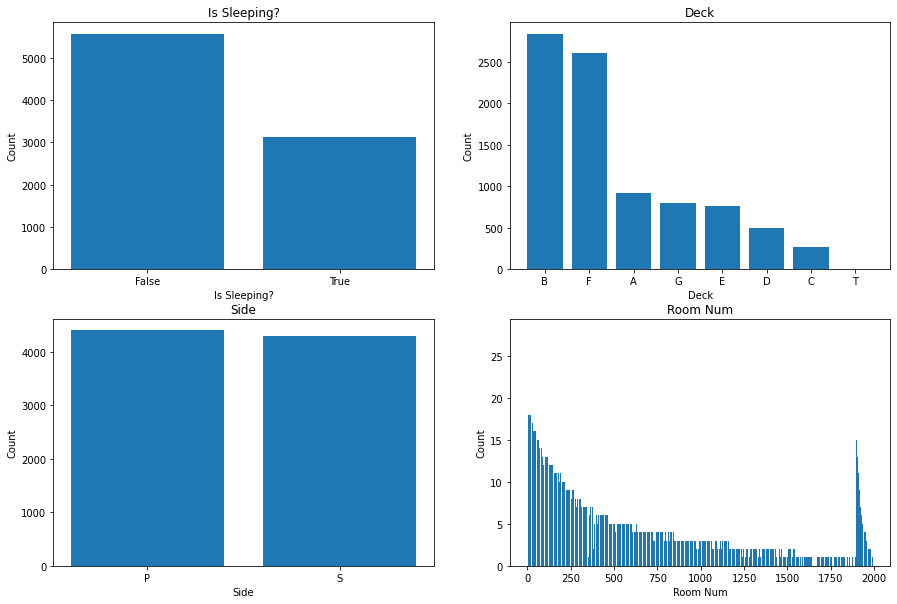

In [52]:
plt.figure()

plt.subplot(2,2,1)
plt.bar(["False","True"],train_df["CryoSleep"].value_counts())
plt.title("Is Sleeping?")
plt.ylabel("Count")
plt.xlabel("Is Sleeping?")

plt.subplot(2,2,2)
plt.bar(train_df["Deck"].dropna().unique(),train_df["Deck"].value_counts())
plt.title("Deck")
plt.xlabel("Deck")
plt.ylabel("Count")

plt.subplot(2,2,3)
plt.bar(train_df["Side"].dropna().unique(),train_df["Side"].value_counts())
plt.title("Side")
plt.xlabel("Side")
plt.ylabel("Count")

plt.subplot(2,2,4)
plt.bar(train_df["Num"].unique(),train_df["Num"].value_counts())
plt.title("Room Num")
plt.xlabel("Room Num")
plt.ylabel("Count")

plt.show()

# Labeling, normalizing, encoding and scalling

**Label categorical data to standarize everything (Deck, Side).**

In [53]:
YouShallNotPass!! #This is here to stop the "Run All"

SyntaxError: invalid syntax (1098059078.py, line 1)

In [54]:
train_df = train_df.drop('F_Name', axis=1)
test_df = test_df.drop('F_Name', axis=1)
train_df = train_df.drop('L_Name', axis=1)
test_df = test_df.drop('L_Name', axis=1)

In [ ]:
#train_df = pd.get_dummies(train_df,columns=["HomePlanet", "Destination", "Deck", "Side"], drop_first=True)
#test_df = pd.get_dummies(test_df,columns=["HomePlanet", "Destination", "Deck", "Side"], drop_first=True)

In [55]:
label_encoder = LabelEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='category':
        train_df[i]=label_encoder.fit_transform(train_df[i])

for i in list(test_df.columns):
    if test_df[i].dtype=='category':
        test_df[i]=label_encoder.fit_transform(test_df[i])

**Here we make scaler to adjust the numeric data**

In [56]:
mask = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerId_Ticket', 'PassengerId_Unique', 'Num', 'TotalSpent', 'Group_Size']
scaler = MinMaxScaler()

# Scale train df
scaler.fit(train_df[mask])
train_df[mask] = scaler.transform(train_df[mask])

# Scale test df
scaler.fit(test_df[mask])
test_df[mask] = scaler.transform(test_df[mask])

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,PassengerId_Unique,IsGrouped,Group_Size,Deck,Num,Side,TotalSpent,IsAdult,IsMiddleAge,IsOldAdult
0,0001_01,1,False,2,0.493671,False,0.000000,0.000000,0.000000,0.000000,...,0.000000,False,0.000000,1,0.000000,0,0.000000,True,False,False
1,0002_01,0,False,2,0.303797,False,0.007608,0.000302,0.001064,0.024500,...,0.000000,False,0.000000,5,0.000000,1,0.020452,True,False,False
2,0003_01,1,False,2,0.734177,True,0.003001,0.119948,0.000000,0.299670,...,0.000000,True,0.142857,0,0.000000,1,0.288521,False,True,False
3,0003_02,1,False,2,0.417722,False,0.000000,0.043035,0.015793,0.148563,...,0.142857,True,0.142857,0,0.000000,1,0.143830,True,False,False
4,0004_01,0,False,2,0.202532,False,0.021149,0.002348,0.006428,0.025214,...,0.000000,False,0.000000,5,0.000502,1,0.030317,False,False,False


In [57]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'PassengerId_Ticket', 'PassengerId_Unique', 'IsGrouped',
       'Group_Size', 'Deck', 'Num', 'Side', 'TotalSpent', 'IsAdult',
       'IsMiddleAge', 'IsOldAdult'],
      dtype='object')

**Now transform bool data into 0 and 1s**

In [58]:
#onehot = OneHotEncoder()
label_encoder = LabelEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='bool':
        train_df[i]=label_encoder.fit_transform(train_df[i])
        
for i in list(test_df.columns):
    if test_df[i].dtype=='bool':
        test_df[i]=label_encoder.fit_transform(test_df[i])

**Now we got just numericall data**
FINAL TRAIN DATA FRAME

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         8693 non-null   object 
 1   HomePlanet          8693 non-null   int64  
 2   CryoSleep           8693 non-null   int64  
 3   Destination         8693 non-null   int64  
 4   Age                 8693 non-null   float64
 5   VIP                 8693 non-null   int64  
 6   RoomService         8693 non-null   float64
 7   FoodCourt           8693 non-null   float64
 8   ShoppingMall        8693 non-null   float64
 9   Spa                 8693 non-null   float64
 10  VRDeck              8693 non-null   float64
 11  Transported         8693 non-null   int64  
 12  PassengerId_Ticket  8693 non-null   float64
 13  PassengerId_Unique  8693 non-null   float64
 14  IsGrouped           8693 non-null   int64  
 15  Group_Size          8693 non-null   float64
 16  Deck  

In [60]:
train_df.head(10).style.background_gradient(cmap="Blues")

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size,Deck,Num,Side,TotalSpent,IsAdult,IsMiddleAge,IsOldAdult
0,0001_01,1,0,2,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,1,0.000000,0,0.000000,1,0,0
1,0002_01,0,0,2,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,1,0.000108,0.000000,0,0.000000,5,0.000000,1,0.020452,1,0,0
2,0003_01,1,0,2,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,0,0.000216,0.000000,1,0.142857,0,0.000000,1,0.288521,0,1,0
3,0003_02,1,0,2,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,0,0.000216,0.142857,1,0.142857,0,0.000000,1,0.143830,1,0,0
4,0004_01,0,0,2,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,1,0.000323,0.000000,0,0.000000,5,0.000502,1,0.030317,0,0,0
5,0005_01,0,0,1,0.556962,0,0.000000,0.016201,0.000000,0.012986,0.000000,1,0.000431,0.000000,0,0.000000,5,0.000000,0,0.021508,0,1,0
6,0006_01,0,0,2,0.329114,0,0.002932,0.051622,0.000128,0.000000,0.000000,1,0.000539,0.000000,1,0.142857,5,0.001004,1,0.044016,1,0,0
7,0006_02,0,1,2,0.354430,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000539,0.142857,1,0.142857,6,0.000000,1,0.000000,1,0,0
8,0007_01,0,0,2,0.443038,0,0.000000,0.026331,0.000724,0.009639,0.000000,1,0.000647,0.000000,0,0.000000,5,0.001505,1,0.028288,1,0,0
9,0008_01,1,1,0,0.177215,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000754,0.000000,1,0.285714,1,0.000502,0,0.000000,0,0,0


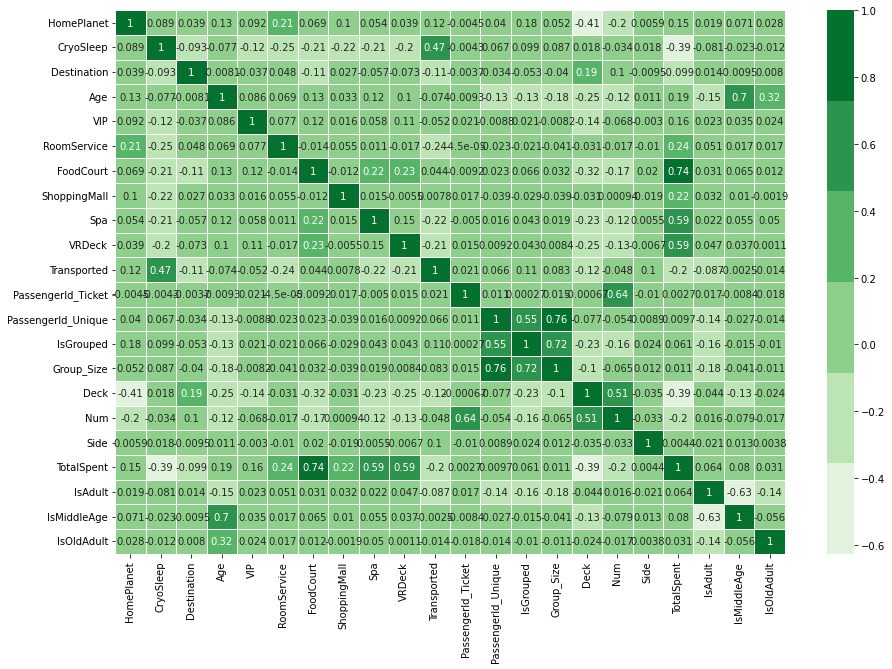

In [70]:
# creating a colormap
colormap = sns.color_palette("Greens")
  
# creating a heatmap using the colormap
ax = sns.heatmap(train_df.corr(), cmap=colormap, annot=True, linewidths=1)

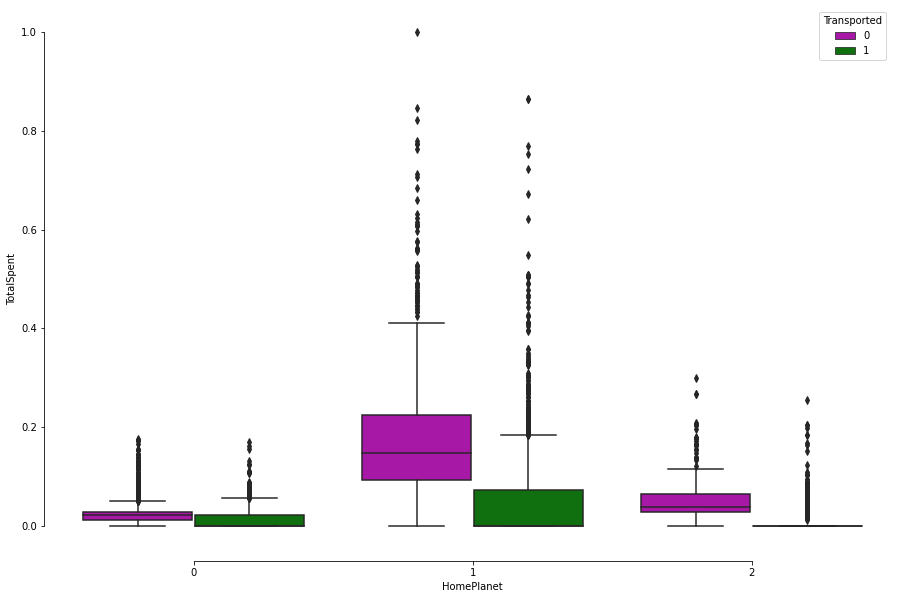

In [75]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="HomePlanet", y="TotalSpent",
            hue="Transported", palette=["m", "g"],
            data=train_df)
sns.despine(offset=10, trim=True)

   #                                         **INIT TRAINING MODELS**

In [ ]:
YouShallNotPass2.0! #To stop code auto run all

**Setting up the variables**

In [61]:
X = train_df.drop(['PassengerId', 'Transported'], axis=1)
y = train_df['Transported']

df_test = test_df.drop(['PassengerId'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [62]:
#Turn off the warning of optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

### CATBOOST

Set up optuna parameters

In [78]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
#        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

run study

In [79]:
start_time = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Study took ",(time.time()-start_time), " seconds...")

Study took  283.76488161087036  seconds...


In [80]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8282208588957055
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.0863798872800635
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.6465011135345788


In [81]:
dict(trial.params.items())

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.0863798872800635,
 'depth': 5,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.6465011135345788}

use params to fit the model. Yes! I know! I am entering the parameters manually. My brain is tired

In [86]:
start_time = time.time()

print("*** STARTING TRAINING CATBOOST MODEL ***\n")

model = CatBoostClassifier(iterations=15000, verbose=False, depth=5, objective="CrossEntropy",
                          boosting_type="Plain", bootstrap_type="Bernoulli",
                          colsample_bylevel=0.0863798872800635, subsample=0.6465011135345788)

#Fit the model
model.fit(X_train,y_train)

print("*** FINISHED TRAINING IN: ", (time.time()-start_time), " SECONDS ***\n")


*** STARTING TRAINING CATBOOST MODEL ***

*** FINISHED TRAINING IN:  22.821954250335693  SECONDS ***



In [87]:
CatPred = model.predict(X_test)

In [88]:
print("Performance on train data:", model.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, CatPred, average='micro'))

Performance on train data: 0.9642583218285014
Performance on validation data: 0.7920883164673413


In [89]:
model.feature_importances_

array([7.0225095 , 5.0281867 , 3.09549904, 6.08391213, 0.64406675,
       6.28911058, 5.74910008, 4.46554821, 8.41710405, 7.63145688,
       7.04978075, 2.23450419, 1.76009069, 2.49407013, 8.36114714,
       7.6615242 , 4.382003  , 7.90373215, 1.87299063, 1.56421948,
       0.28944371])

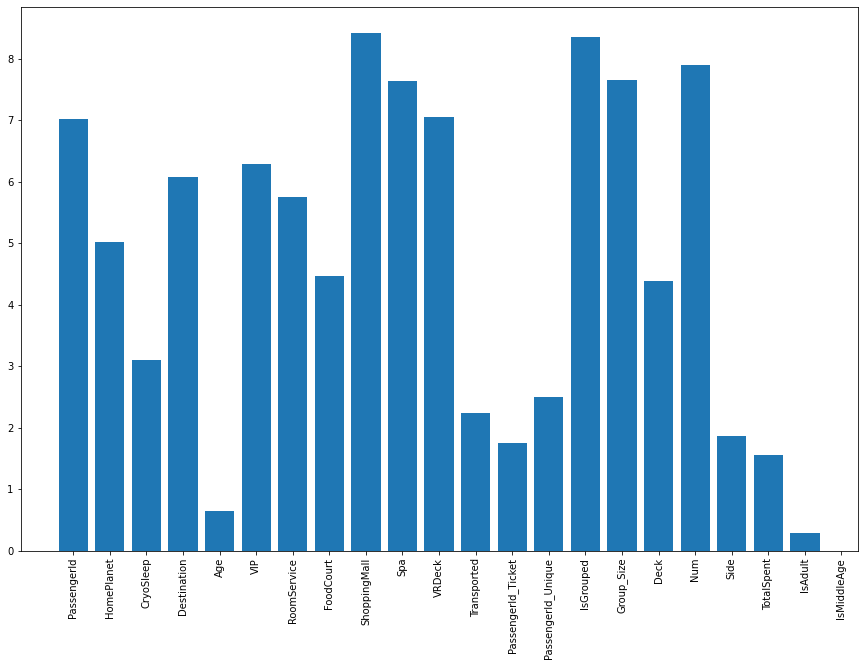

In [90]:
train_df.columns.array

asdf1 = pd.Series(model.feature_importances_)
asdf2 = pd.Series(train_df.columns.array)

dictxd = {"columnas": asdf2, "importancia": asdf1}
df55 = pd.DataFrame(dictxd)
plt.figure()
plt.bar(df55["columnas"].unique(),df55["importancia"])
plt.xticks(rotation=90)
plt.show()



In [138]:
CatPred = model.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': CatPred.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2260
False    2017
Name: Transported, dtype: int64

In [139]:
output.to_csv("CatBoostClassifier_SubmissionV5.0.csv")

# LGBM Classifier

In [ ]:
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

In [92]:
#Optuna tuner

start_time = time.time()

def objective(trial):
    data, target = X, y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.20)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "device": "gpu"
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy
    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
    
print("\n\nThis took ",(time.time()-start_time), " seconds...")

Number of finished trials: 100
Best trial:
  Value: 0.8297872340425532
  Params: 
    lambda_l1: 6.923892130997347e-08
    lambda_l2: 7.559677421530826e-05
    num_leaves: 93
    feature_fraction: 0.872402994262602
    bagging_fraction: 0.6029288065346937
    bagging_freq: 4
    min_child_samples: 87


This took  87.91255640983582  seconds...


In [93]:
start_time = time.time()

print("*** STARTING TRAINING CATBOOST MODEL ***\n")

params2 = { 'lambda_l1': [6.923892130997347e-08],
    'lambda_l2': [7.559677421530826e-05],
    'num_leaves': [93],
    'feature_fraction': [0.872402994262602],
    'bagging_fraction': [0.6029288065346937],
    'bagging_freq': [4],
    'min_child_samples': [87],
           'n_jobs': [-1]
        }

lgbmodel = lgb.LGBMClassifier(**params2)

#Fit the model

lgbmodel.fit(X_train,y_train)

print("*** FINISHED TRAINING IN: ", (time.time()-start_time), " SECONDS ***\n")

*** STARTING TRAINING CATBOOST MODEL ***

[LightGBM] [Warning] bagging_fraction is set=0.6029288065346937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6029288065346937
[LightGBM] [Warning] lambda_l1 is set=6.923892130997347e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.923892130997347e-08
[LightGBM] [Warning] feature_fraction is set=0.872402994262602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.872402994262602
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.559677421530826e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.559677421530826e-05
*** FINISHED TRAINING IN:  0.2306668758392334  SECONDS ***



In [94]:
# predict the results
y_pred=lgbmodel.predict(X_test)

In [95]:
print("Performance on train data:", lgbmodel.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, y_pred, average='micro'))


Performance on train data: 0.8780487804878049
Performance on validation data: 0.8008279668813246


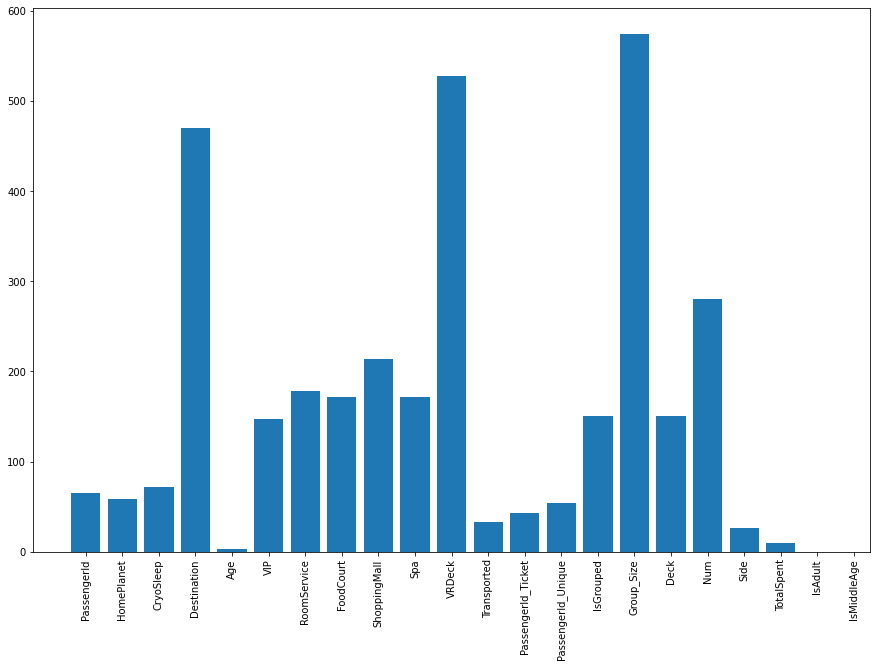

In [98]:
lgbmodel.feature_importances_

train_df.columns.array

asdf1 = pd.Series(lgbmodel.feature_importances_)
asdf2 = pd.Series(train_df.columns.array)

dictxd = {"columnas": asdf2, "importancia": asdf1}
df55 = pd.DataFrame(dictxd)
plt.figure()
plt.bar(df55["columnas"].unique(),df55["importancia"])
plt.xticks(rotation=90)
plt.show()

In [140]:
y_pred = lgbmodel.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': y_pred.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2303
False    1974
Name: Transported, dtype: int64

In [141]:
output.to_csv("LGBMClassifier_SubmissionV7.0.csv")

## **XGB Classifier**

In [102]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.20)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method" : 'gpu_hist',
        "gpu_id":0,
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [103]:
start_time = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print("\nthis took ",(time.time()-start_time), " seconds...")

Number of finished trials:  100
Best trial:
  Value: 0.8188614146060954
  Params: 
    booster: dart
    lambda: 0.001062932783198321
    alpha: 1.3474942085010244e-06
    subsample: 0.4889644972181981
    colsample_bytree: 0.8569452020527424
    max_depth: 7
    min_child_weight: 3
    eta: 0.0005942240952286099
    gamma: 1.6032143163949408e-08
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 0.0001920122168997298
    skip_drop: 4.934280219806638e-06

this took  13.173140048980713  seconds...


In [104]:
start_time = time.time()
xgb_model = xgb.XGBClassifier(booster="dart", reg_lambda=0.001062932783198321, reg_alpha=1.3474942085010244e-06,
                              subsample=0.4889644972181981, colsample_bytree=0.8569452020527424,
                              max_depth=7, min_child_weight=3, eta=0.0005942240952286099,
                              gamma=1.6032143163949408e-08, grow_policy="lossguide", sample_type="uniform",
                             normalize_type="tree", rate_drop=0.0001920122168997298,
                              skip_drop=4.934280219806638e-06)

modelxgb = xgb_model.fit(X_train, y_train)

print("\nThis took ", (time.time()-start_time), " seconds...")


This took  4.617300987243652  seconds...


In [105]:
y_valid_pred = modelxgb.predict(X_test)

In [106]:
print("Performance on train data:", modelxgb.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, y_valid_pred, average='micro'))

Performance on train data: 0.83172265684921
Performance on validation data: 0.7865685372585097


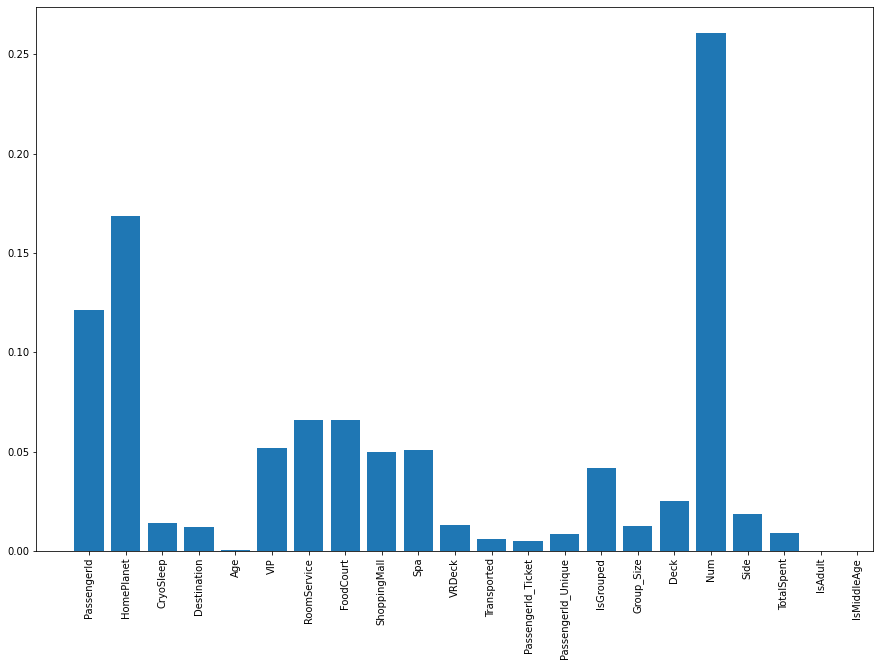

In [107]:
modelxgb.feature_importances_

train_df.columns.array

asdf1 = pd.Series(modelxgb.feature_importances_)
asdf2 = pd.Series(train_df.columns.array)

dictxd = {"columnas": asdf2, "importancia": asdf1}
df55 = pd.DataFrame(dictxd)
plt.figure()
plt.bar(df55["columnas"].unique(),df55["importancia"])
plt.xticks(rotation=90)
plt.show()

**Create output DataFrame with prediction**

In [142]:
predicted_y = modelxgb.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': predicted_y.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2379
False    1898
Name: Transported, dtype: int64

**Export Data for submission**

In [143]:
output.to_csv("XGBClassifier_SubmissionV7.0.csv")

## **Neural Network**

In [111]:
start_time = time.time()

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf = MLPClassifier(max_iter=500, hidden_layer_sizes=tuple(layers))
    clf.fit(X_train, y_train)
    
    return clf.score(X_test, y_test)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("\nThis took ",(time.time()-start_time)," seconds...")


This took  1336.6099922657013  seconds...


In [112]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

Number of finished trials:  100
Best trial:
  Value: 0.8164673413063478
  Params: 
    n_layers: 1
    n_units_0: 49


In [113]:
start_time = time.time()

clf = MLPClassifier(max_iter=500, hidden_layer_sizes=(49,))

clf.fit(X_train,y_train)

print("\nMLPC Training model tooks: ", (time.time()-start_time), " seconds.")


MLPC Training model tooks:  9.495670557022095  seconds.


In [114]:
mlpcresult = clf.predict(X_test)

In [115]:
print("Performance on train data:", clf.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, mlpcresult, average='micro'))

Performance on train data: 0.8200644270593649
Performance on validation data: 0.7934682612695492


In [144]:
mlpcresult2 = clf.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': mlpcresult2.astype('bool')})
#output["Transported"].value_counts()
output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2298
False    1979
Name: Transported, dtype: int64

In [145]:
output.to_csv("MPLCSubmissionV7.0.csv")

## **RandomForestClassifier**

In [129]:
# RandomForest

start_time = time.time()
max_depth = [80,90,100,110]
n_estimators = [10,25,50,100]
max_features = ['auto', 'sqrt']
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True,False]


parameters_grid = {'n_estimators': n_estimators,
                   'max_depth' : max_depth,
                  'max_features': max_features,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

rf_model = RandomForestClassifier()
rf_Grid = RandomizedSearchCV(estimator = rf_model, param_distributions = parameters_grid, cv=5, verbose=0, n_jobs=-1)
rf_Grid.fit(X_train,y_train)

print(f"This took: {(time.time()-start_time)} seconds")

This took: 13.874963998794556 seconds


In [133]:
rf_Grid.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [137]:
print(f'Train Accuracy - : {rf_Grid.score(X_train,y_train):3f}')
print(f'Test Accuracy - : {rf_Grid.score(X_test,y_test):3f}')

Train Accuracy - : 0.911029
Test Accuracy - : 0.796228


In [135]:
rf_Grid.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [146]:
y_pred3 = rf_Grid.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': y_pred3.astype('bool')})
output["Transported"].value_counts()

True     2291
False    1986
Name: Transported, dtype: int64

In [147]:
output.to_csv('RandomForestv7.1.csv', index=False)

# ENSEMBLED MODEL

In [149]:
start_time = time.time()
Ensemble_HV = VotingClassifier(estimators= [('CATBOOST', model),
                                            ('LGBM', lgbmodel),
                                           ('XBG', modelxgb),
                                           ('MLPC', clf),
                                           ('RANDOMFOREST', rf_Grid)
                                           ],
                                            voting = 'hard',
                                            n_jobs=-1)

# Return Accuracy Scores
#cv_HV = cross_val_score(Ensemble_HV, X, y, scoring='accuracy')

#print('Hard Voting Classifier:' , cv_HV.mean())
#print("\nThis took :",(time.time()-start_time), " seconds...")

In [ ]:
#print('Hard Voting Classifier:' , cv_HV.mean())

In [150]:
ensemble_model = Ensemble_HV.fit(X, y)

[LightGBM] [Warning] bagging_fraction is set=0.6029288065346937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6029288065346937
[LightGBM] [Warning] lambda_l1 is set=6.923892130997347e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.923892130997347e-08
[LightGBM] [Warning] feature_fraction is set=0.872402994262602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.872402994262602
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.559677421530826e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.559677421530826e-05


In [151]:
e_pred = ensemble_model.predict(X_test)

In [152]:
print("Performance on train data:", ensemble_model.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, e_pred, average='micro'))

Performance on train data: 0.8956895229329652
Performance on validation data: 0.8877644894204232


In [153]:
e_pred = ensemble_model.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': e_pred.astype('bool')})
output["Transported"].value_counts()


True     2291
False    1986
Name: Transported, dtype: int64

In [154]:
output.to_csv('Ensemble_Model_V5.0.csv', index=False)